In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models,transforms, datasets
import torch.optim as optim
import cv2
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Explore Dataset

In [2]:
dataset_folder = '/kaggle/input/parking-lot-detection-counter/parking/clf-data'
total_classes = 0

for class_folder in os.listdir(dataset_folder):
    class_folder_path = os.path.join(dataset_folder, class_folder)
    if os.path.isdir(class_folder_path):
        total_classes += 1
        images = os.listdir(class_folder_path)
        num_images = len(images)
        print(f"Class: {class_folder}, Number of Images: {num_images}")

print(f"Total number of classes: {total_classes}")

Class: empty, Number of Images: 3045
Class: not_empty, Number of Images: 3045
Total number of classes: 2


In [3]:
train_dir = '/kaggle/input/parking-lot-detection-counter/parking/clf-data'
num_classes = 2
image_shape = (64, 64)

# Prepare Dataset for the Model

In [4]:
class MakeDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.classes = sorted(os.listdir(root_folder), key=self.natural_key)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.make_dataset()

    def natural_key(self, string_):
        try:
            return int(string_)
        except ValueError:
            return string_

    def make_dataset(self):
        images = []
        for label in self.classes:
            label_folder = os.path.join(self.root_folder, label)
            for image_name in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image_name)
                item = (image_path, self.class_to_idx[label])
                images.append(item)
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path, label = self.images[index]
        try:
            image = Image.open(image_path).convert("RGB")
        except (OSError, IOError) as e:
            print(f"Skipping corrupted image: {image_path}, Error: {e}")
            # Return a zero tensor and a dummy label in case of error
            image = Image.new('RGB', (224, 224))  # Assuming the image size to be 224x224
            label = -1  # You might want to handle this label properly later

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
transform = transforms.Compose([
    transforms.Resize(image_shape),
    transforms.ToTensor(),
])

In [6]:
dataset = MakeDataset(train_dir, transform=transform)

In [7]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [8]:
batch_size = 32

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training Samples:


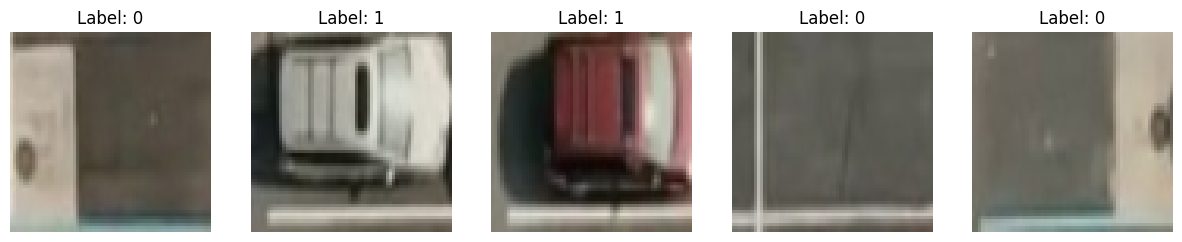

Validation Samples:


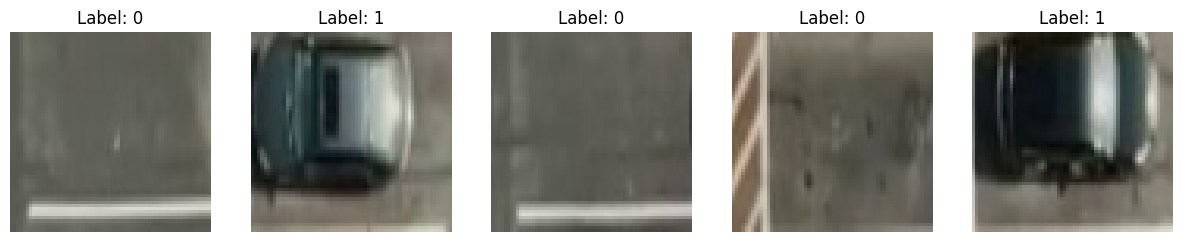

Testing Samples:


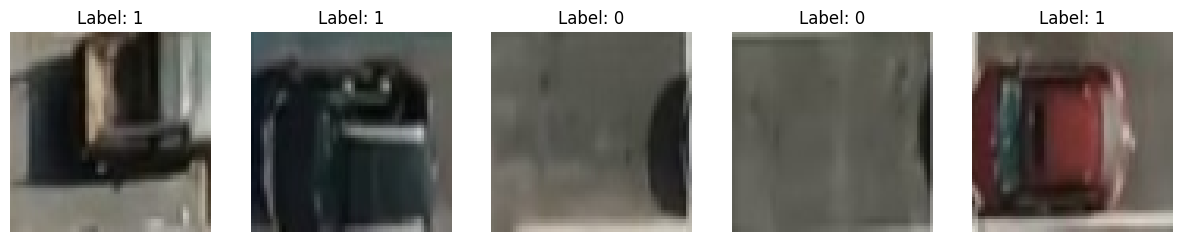

In [10]:
def visualize(loader, num_samples=5):
    # Iterate through the DataLoader to get a batch of data
    for batch_idx, (images, labels) in enumerate(loader):
        # Plot the images
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        for i in range(num_samples):
            ax = axes[i]
            ax.imshow(np.transpose(images[i], (1, 2, 0)))
            ax.set_title(f"Label: {labels[i]}")
            ax.axis('off')
        plt.show()
        break  # Stop after displaying the first batch

# Visualize samples from the training loader
print("Training Samples:")
visualize(train_loader)

# Visualize samples from the validation loader
print("Validation Samples:")
visualize(val_loader)

print("Testing Samples:")
visualize(test_loader)

In [11]:
model = models.resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


In [12]:
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
model = model.to(device)

In [15]:
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
num_epochs = 5
desired_training_accuracy = 99.999
early_stopping_threshold = 5
early_stopping_counter = 0
best_val_loss = float('inf')

In [17]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
predictions = []
targets = []

In [18]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        if -1 in labels:
            continue  # Skip the batch if it contains dummy labels

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Print training loss and accuracy every 100 batches
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}, '
                  f'Training Loss: {running_loss / 100}, Training Accuracy: {100 * correct_train / total_train}%')

    # Calculate training accuracy after the epoch
    training_accuracy = correct_train / total_train

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if -1 in labels:
                continue  # Skip the batch if it contains dummy labels

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    # Calculate validation accuracy after the epoch
    validation_accuracy = correct_val / total_val
    average_val_loss = val_running_loss / len(val_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {running_loss / len(train_loader)}, '
          f'Training Accuracy: {100 * training_accuracy}%, '
          f'Validation Loss: {average_val_loss}, '
          f'Validation Accuracy: {100 * validation_accuracy}%')

    # Append training and validation metrics for plotting
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(training_accuracy)
    val_losses.append(average_val_loss)
    val_accuracies.append(validation_accuracy)

    scheduler.step()

Epoch 1/5, Batch 100/153, Training Loss: 0.03267876329176943, Training Accuracy: 98.75%
Epoch 1/5, Training Loss: 0.02178166564337124, Training Accuracy: 99.17898193760263%, Validation Loss: 0.0001551111279638917, Validation Accuracy: 100.0%
Epoch 2/5, Batch 100/153, Training Loss: 0.0109843271884165, Training Accuracy: 99.625%
Epoch 2/5, Training Loss: 0.00844442888800366, Training Accuracy: 99.692118226601%, Validation Loss: 9.77744087094834e-05, Validation Accuracy: 100.0%
Epoch 3/5, Batch 100/153, Training Loss: 0.0008887956468424818, Training Accuracy: 99.96875%
Epoch 3/5, Training Loss: 0.001421876953102232, Training Accuracy: 99.95894909688013%, Validation Loss: 0.0001164533845440019, Validation Accuracy: 100.0%
Epoch 4/5, Batch 100/153, Training Loss: 0.0006756380947263097, Training Accuracy: 99.96875%
Epoch 4/5, Training Loss: 0.0004846030502282696, Training Accuracy: 99.97947454844007%, Validation Loss: 3.446862733653688e-05, Validation Accuracy: 100.0%
Epoch 5/5, Batch 100/1

In [19]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    print(f'Test Accuracy: {100 * test_accuracy}%')

    return test_accuracy

test_accuracy = evaluate_model(model, test_loader, device)

Test Accuracy: 100.0%


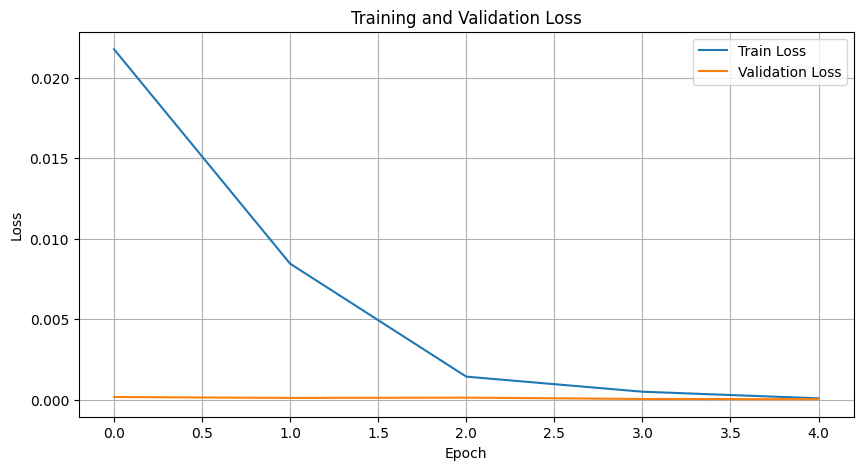

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

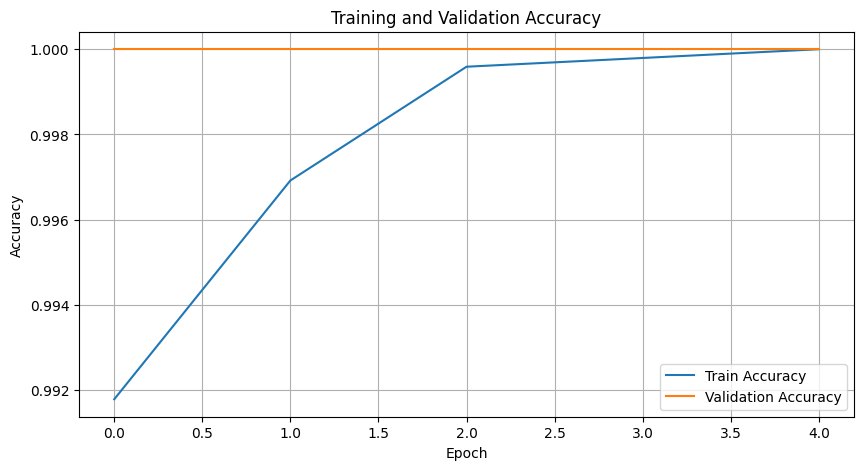

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Test with The Full Video

In [22]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [25]:
def empty_or_not(spot_bgr):
    if spot_bgr is None or spot_bgr.size == 0:
        return NOT_EMPTY

    try:
        # Convert BGR image to RGB and PIL Image
        spot_rgb = cv2.cvtColor(spot_bgr, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(spot_rgb)

        # Apply transformation
        img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

        # Get model prediction
        with torch.no_grad():
            output = model(img_tensor)
            prediction = torch.argmax(output, dim=1).item()

        return EMPTY if prediction == 0 else NOT_EMPTY

    except Exception as e:
        print(f"Error processing image: {e}")
        return NOT_EMPTY

In [26]:
mask_path = '/kaggle/input/parking-lot-detection-counter/parking/mask_1920_1080.png'
video_path = '/kaggle/input/parking-lot-detection-counter/parking/parking_1920_1080.mp4'
output_video_path = '/kaggle/working/output_video.mp4'

In [27]:
mask = cv2.imread(mask_path, 0)

In [28]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

In [29]:
connected_components = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

In [30]:
def get_parking_spots_bboxes(connected_components):
    (totalLabels, label_ids, values, centroid) = connected_components
    slots = []
    coef = 1
    for i in range(1, totalLabels):
        x1 = int(values[i, cv2.CC_STAT_LEFT] * coef)
        y1 = int(values[i, cv2.CC_STAT_TOP] * coef)
        w = int(values[i, cv2.CC_STAT_WIDTH] * coef)
        h = int(values[i, cv2.CC_STAT_HEIGHT] * coef)
        slots.append([x1, y1, w, h])
    return slots

In [31]:
spots = get_parking_spots_bboxes(connected_components)

In [32]:
spots_status = [None for _ in spots]
diffs = [None for _ in spots]
previous_frame = None

In [33]:
frame_nmr = 0
ret = True
step = 30

In [34]:
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame.shape[1], frame.shape[0]))

In [35]:
def calc_diff(im1, im2):
    return np.abs(np.mean(im1) - np.mean(im2))

In [36]:
EMPTY = True
NOT_EMPTY = False

In [37]:
while ret:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_nmr % step == 0 and previous_frame is not None:
        # Process frame
        for spot_indx, spot in enumerate(spots):
            x1, y1, w, h = spot
            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]
            diffs[spot_indx] = calc_diff(spot_crop, previous_frame[y1:y1 + h, x1:x1 + w, :])

    if frame_nmr % step == 0:
        if previous_frame is None:
            arr_ = range(len(spots))
        else:
            arr_ = [j for j in np.argsort(diffs) if diffs[j] / np.amax(diffs) > 0.4]
        for spot_indx in arr_:
            spot = spots[spot_indx]
            x1, y1, w, h = spot
            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]
            spot_status = empty_or_not(spot_crop)
            spots_status[spot_indx] = spot_status

    if frame_nmr % step == 0:
        previous_frame = frame.copy()

    for spot_indx, spot in enumerate(spots):
        spot_status = spots_status[spot_indx]
        x1, y1, w, h = spots[spot_indx]
        color = (0, 255, 0) if spot_status else (0, 0, 255)
        frame = cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), color, 2)

    cv2.rectangle(frame, (80, 20), (1000, 80), (0, 0, 0), -1)
    num_empty = sum(1 for status in spots_status if status == EMPTY)
    num_not_empty = len(spots) - num_empty
    total_slots = len(spots)
    status_text = f'Empty: {num_empty}, Not Empty: {num_not_empty}, Total Slots: {total_slots}'
    cv2.putText(frame, status_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Write the processed frame to the output video
    out.write(frame)

    frame_nmr += 1

In [38]:
cap.release()
out.release()

# Test with The Cropped Video

In [39]:
mask_path = '/kaggle/input/parking-lot-detection-counter/parking/mask_crop.png'
video_path = '/kaggle/input/parking-lot-detection-counter/parking/parking_crop.mp4'
output_video_path = '/kaggle/working/cropped_output_video.mp4'

In [40]:
mask = cv2.imread(mask_path, 0)

In [41]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

In [42]:
connected_components = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

In [43]:
spots = get_parking_spots_bboxes(connected_components)

In [44]:
spots_status = [None for _ in spots]
diffs = [None for _ in spots]
previous_frame = None

frame_nmr = 0
ret = True
step = 30

In [45]:
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame.shape[1], frame.shape[0]))

In [46]:
while ret:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_nmr % step == 0 and previous_frame is not None:
        # Process frame
        for spot_indx, spot in enumerate(spots):
            x1, y1, w, h = spot
            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]
            diffs[spot_indx] = calc_diff(spot_crop, previous_frame[y1:y1 + h, x1:x1 + w, :])

    if frame_nmr % step == 0:
        if previous_frame is None:
            arr_ = range(len(spots))
        else:
            arr_ = [j for j in np.argsort(diffs) if diffs[j] / np.amax(diffs) > 0.4]
        for spot_indx in arr_:
            spot = spots[spot_indx]
            x1, y1, w, h = spot
            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]
            spot_status = empty_or_not(spot_crop)
            spots_status[spot_indx] = spot_status

    if frame_nmr % step == 0:
        previous_frame = frame.copy()

    for spot_indx, spot in enumerate(spots):
        spot_status = spots_status[spot_indx]
        x1, y1, w, h = spots[spot_indx]
        color = (0, 255, 0) if spot_status else (0, 0, 255)
        frame = cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), color, 2)

    cv2.rectangle(frame, (80, 20), (150, 60), (0, 0, 0), -1)
    num_empty = sum(1 for status in spots_status if status == EMPTY)
    num_not_empty = len(spots) - num_empty
    total_slots = len(spots)
    status_text = f'Empty: {num_empty}, Not Empty: {num_not_empty}, Total Slots: {total_slots}'
    cv2.putText(frame, status_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)

    # Write the processed frame to the output  Not Empty : eo
    out.write(frame)

    frame_nmr += 1

In [47]:
cap.release()
out.release()